## Setting up the model

In [43]:
import torch
import torch_geometric
from torch import Tensor
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import time
import torch.nn.functional as F
from torch_geometric.logging import init_wandb, log

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device {device}")



def get_model(dataset):

    class GCN(torch.nn.Module):
        def __init__(self, in_channels, hidden_channels, out_channels):
            super().__init__()
            self.conv1 = GCNConv(in_channels, hidden_channels)
            self.conv2 = GCNConv(hidden_channels, out_channels)

        def forward(self, x: Tensor, edge_index: Tensor, edge_weight = None) -> Tensor:
            # x: Node feature matrix of shape [num_nodes, in_channels]
            # edge_index: Graph connectivity matrix of shape [2, num_edges]
            x = self.conv1(x, edge_index).relu()
            x = self.conv2(x, edge_index)
            return x

    model = GCN(dataset.num_features, 16, dataset.num_classes)
    model.to(device)
    optimizer = torch.optim.Adam([
        dict(params=model.conv1.parameters(), weight_decay=5e-4),
        dict(params=model.conv2.parameters(), weight_decay=0)
    ], lr=0.01)  # Only perform weight-decay on first convolution.

    return model, optimizer

using device cuda


## Setting up utilities for training

In [44]:
import matplotlib.pyplot as plt

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_attr).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


def train_and_test(model, optimizer, epochs, data, name):
    best_val_acc = test_acc = 0
    times = []
    losses = []  # To store loss values
    train_accs = []  # To store training accuracies
    val_accs = []  # To store validation accuracies
    test_accs = []  # To store test accuracies
    for epoch in range(1, epochs + 1):
        start = time.time()
        loss = train(model, optimizer, data)
        train_acc, val_acc, tmp_test_acc = test(model, data)
        
        # Store the metrics
        losses.append(loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(tmp_test_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
        #log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
        times.append(time.time() - start)
    plot(name,times,losses,train_accs,val_accs,test_accs)
    print("acuracy final: "+str(test_accs[-1]))


def plot(name,times,losses,train_accs,val_accs,test_accs):
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(losses, label='Loss')
    plt.title('Loss over epochs Planetoid'+name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title('Accuracy over epochs Planetoid'+name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()  # Display the plots
    print(f'Median time per epoch: {torch.tensor(times).median():.4f}s')

## Multiple Datasets

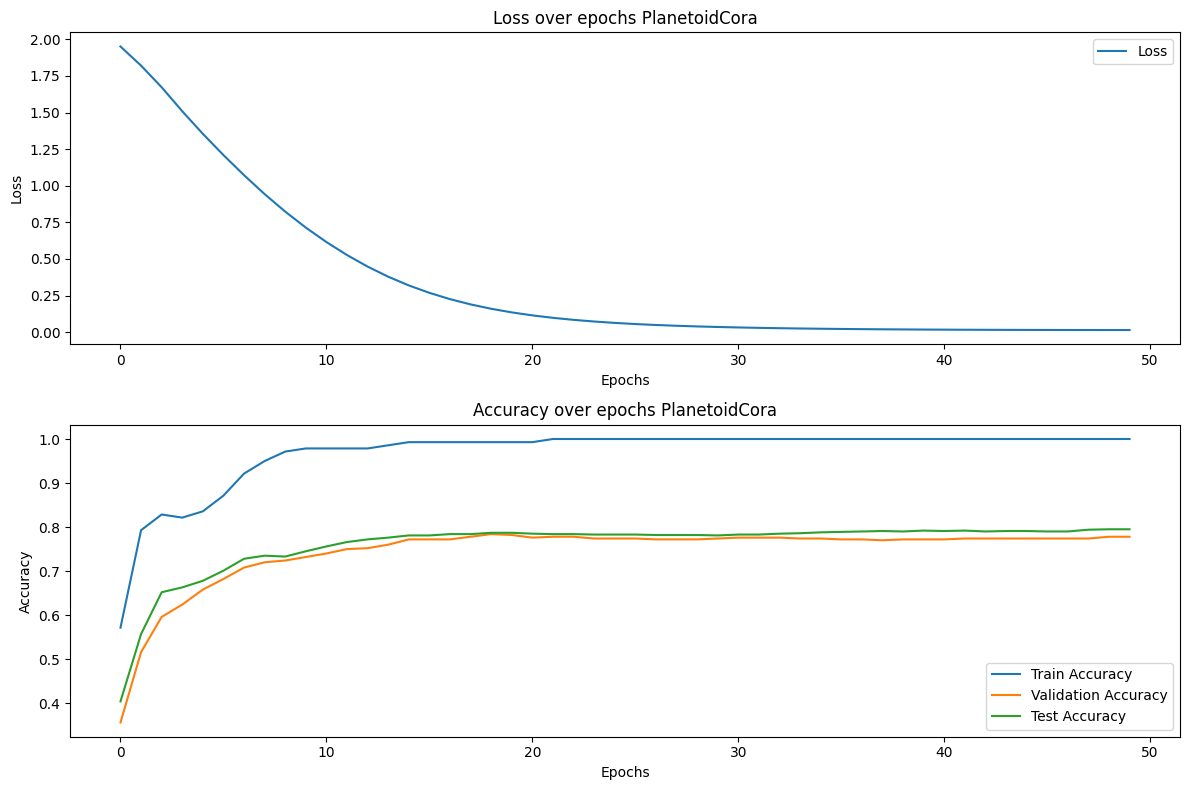

Median time per epoch: 0.0144s
acuracy final: 0.795


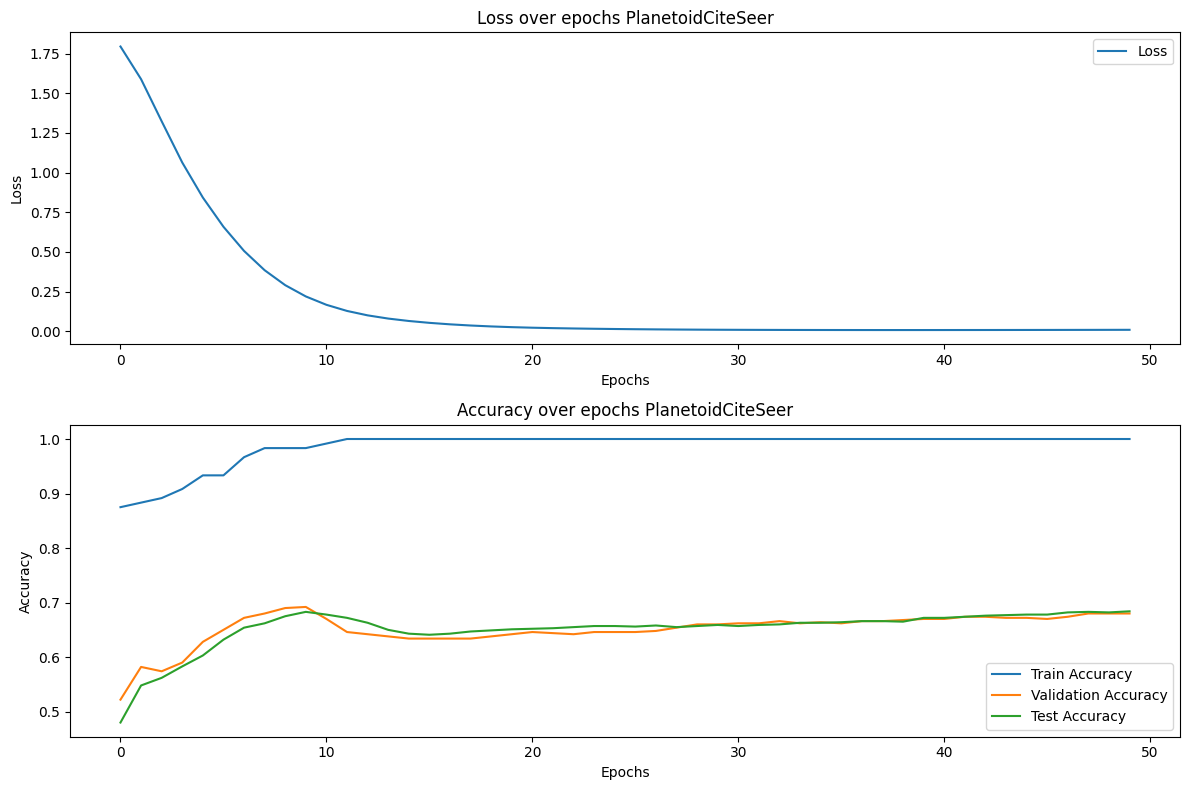

Median time per epoch: 0.0197s
acuracy final: 0.684


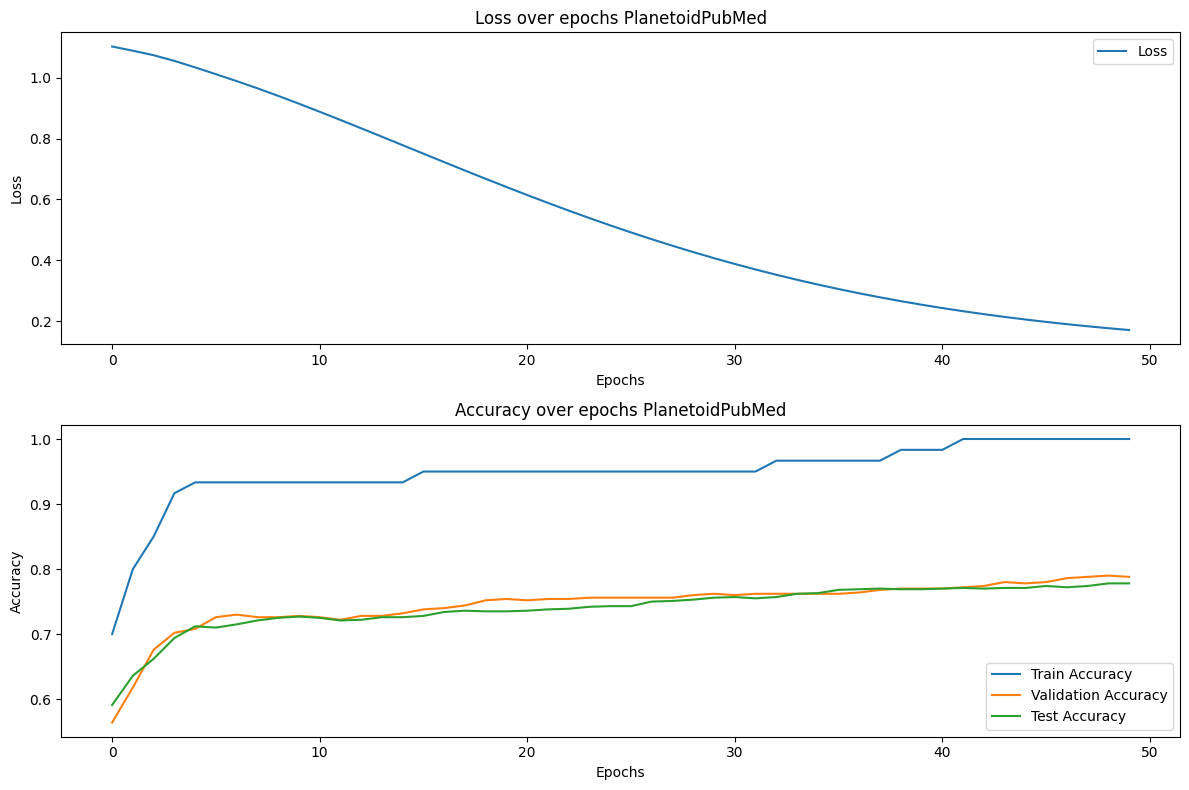

Median time per epoch: 0.0394s
acuracy final: 0.778


In [45]:
data_name = ["Cora","CiteSeer", "PubMed"]
#"CiteSeer", "PubMed"
for name in data_name:
    dataset = Planetoid(root = '.', name = name)

    dataset.to(device)
    data = dataset[0].to(device)
    model, optimizer = get_model(dataset)
    train_and_test(model, optimizer, 50, data, name)

# Testing Diferent Architecures

In [24]:
def get_model3(dataset):

    class GCN(torch.nn.Module):
        def __init__(self, in_channels, hidden_channels, out_channels):
            super().__init__()
            self.conv1 = GCNConv(in_channels, hidden_channels)
            self.conv2 = GCNConv(hidden_channels, out_channels)
            self.dropout = torch.nn.Dropout(0.50)

        def forward(self, x: Tensor, edge_index: Tensor, edge_weight = None) -> Tensor:
            # x: Node feature matrix of shape [num_nodes, in_channels]
            # edge_index: Graph connectivity matrix of shape [2, num_edges]
            x = self.conv1(x, edge_index).relu()
            x = self.dropout(x)
            x = self.conv2(x, edge_index)
            return x

    model = GCN(dataset.num_features, 16, dataset.num_classes)
    model.to(device)
    optimizer = torch.optim.Adam([
        dict(params=model.conv1.parameters(), weight_decay=5e-4),
        dict(params=model.conv2.parameters(), weight_decay=0)
    ], lr=0.01)  # Only perform weight-decay on first convolution.

    return model, optimizer

def get_model2(dataset):

    class GCN(torch.nn.Module):
        def __init__(self, in_channels, hidden_channels, out_channels):
            super().__init__()
            self.conv1 = GCNConv(in_channels, hidden_channels)
            self.conv2 = GCNConv(hidden_channels, out_channels)

        def forward(self, x: Tensor, edge_index: Tensor, edge_weight = None) -> Tensor:
            # x: Node feature matrix of shape [num_nodes, in_channels]
            # edge_index: Graph connectivity matrix of shape [2, num_edges]
            x = self.conv1(x, edge_index).tanh()
            x = self.conv2(x, edge_index)
            return x

    model = GCN(dataset.num_features, 16, dataset.num_classes)
    model.to(device)
    optimizer = torch.optim.Adam([
        dict(params=model.conv1.parameters(), weight_decay=5e-4),
        dict(params=model.conv2.parameters(), weight_decay=0)
    ], lr=0.01)  # Only perform weight-decay on first convolution.

    return model, optimizer

def get_model4(dataset):

    class GCN(torch.nn.Module):
        def __init__(self, in_channels, hidden_channels, out_channels):
            super().__init__()
            self.conv1 = GCNConv(in_channels, hidden_channels)
            self.conv2 = GCNConv(hidden_channels, out_channels)
            self.normal= torch.nn.BatchNorm1d(16)

        def forward(self, x: Tensor, edge_index: Tensor, edge_weight = None) -> Tensor:
            # x: Node feature matrix of shape [num_nodes, in_channels]
            # edge_index: Graph connectivity matrix of shape [2, num_edges]
            x = self.conv1(x, edge_index).relu()
            x= self.normal(x)
            x = self.conv2(x, edge_index)
            return x

    model = GCN(dataset.num_features, 16, dataset.num_classes)
    model.to(device)
    optimizer = torch.optim.Adam([
        dict(params=model.conv1.parameters(), weight_decay=5e-4),
        dict(params=model.conv2.parameters(), weight_decay=0)
    ], lr=0.01)  # Only perform weight-decay on first convolution.

    return model, optimizer



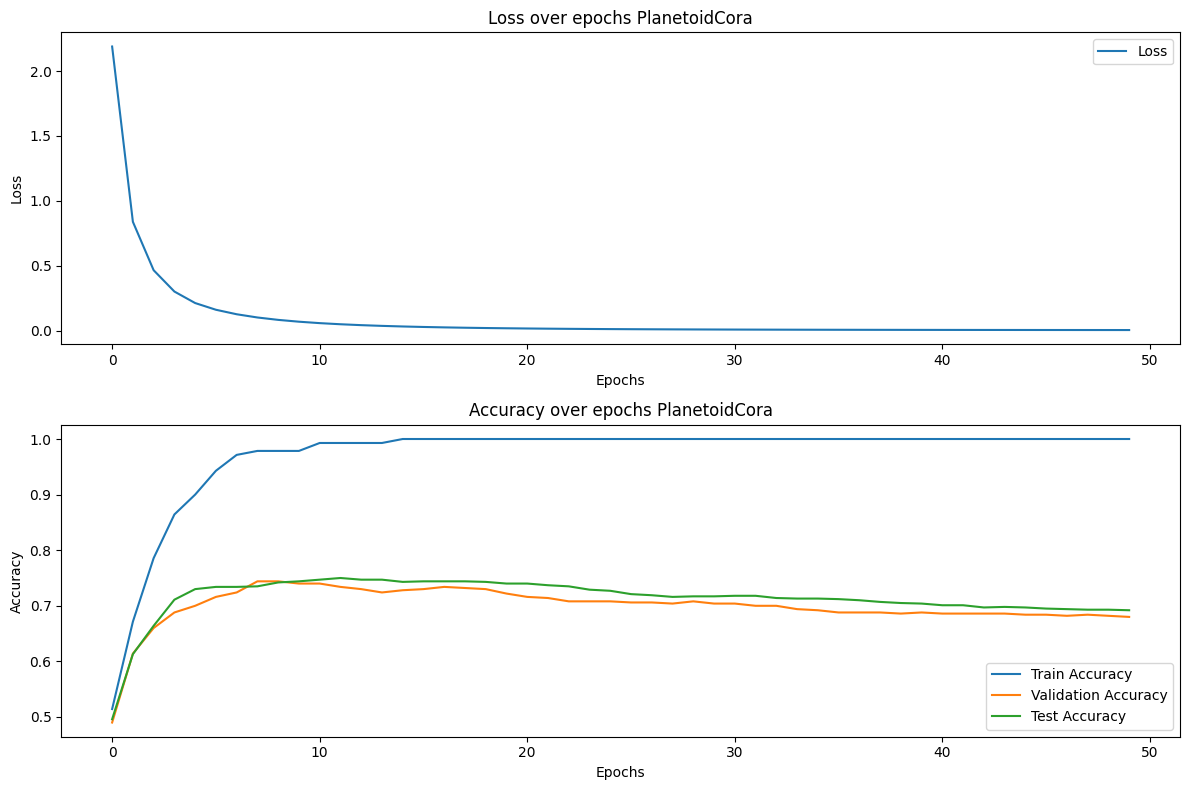

Median time per epoch: 0.0156s
acuracy final: 0.692


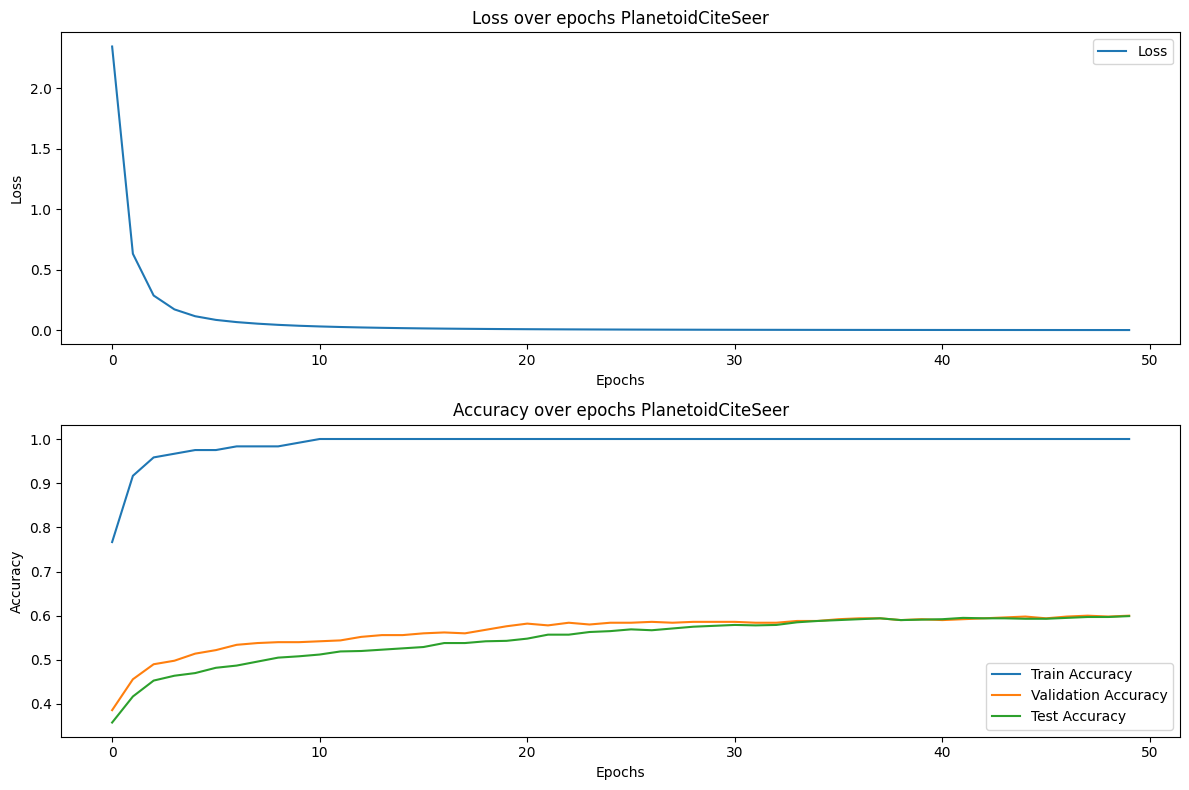

Median time per epoch: 0.0190s
acuracy final: 0.599


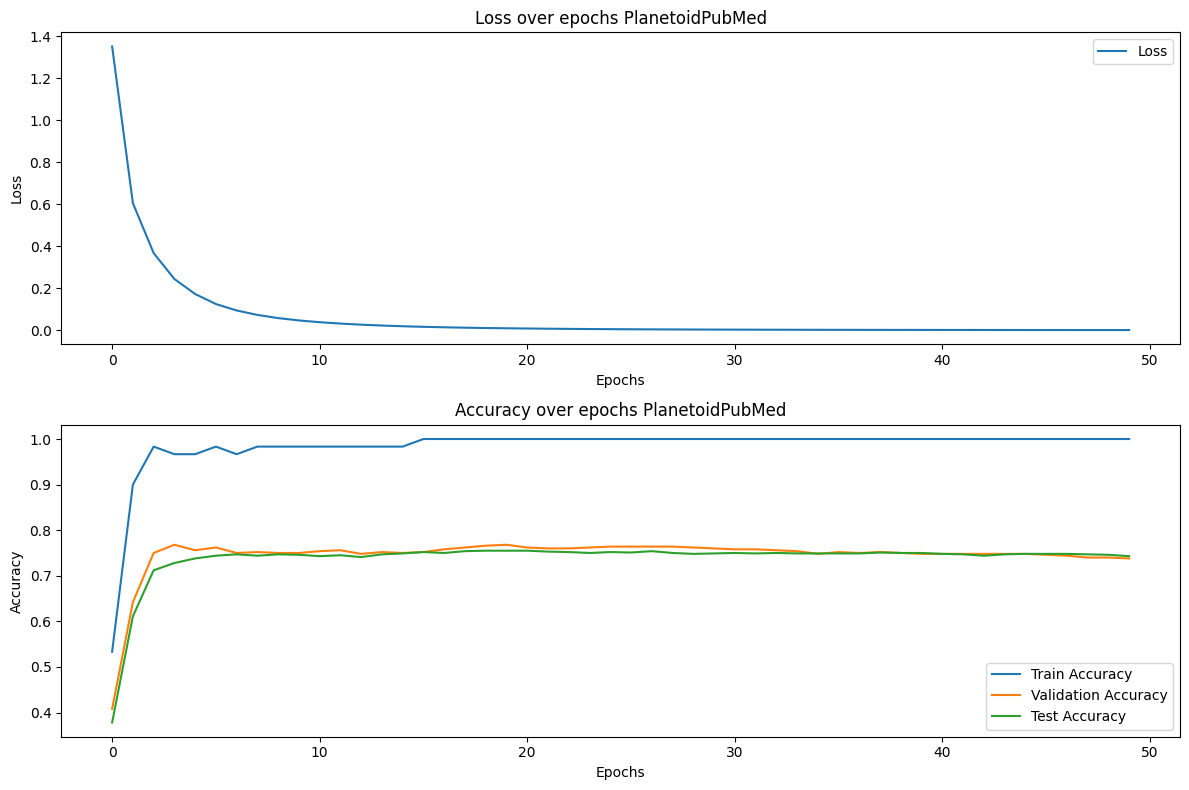

Median time per epoch: 0.0271s
acuracy final: 0.743


In [52]:
data_name = ["Cora","CiteSeer", "PubMed"]

for name in data_name:
    dataset = Planetoid(root = '.', name = name)
    dataset.to(device)
    data = dataset[0].to(device)
    model, optimizer = get_model4(dataset)
    train_and_test(model, optimizer, 50, data, name)